# Tutorial about images

In the context of SMLM you also have to deal with pixelated images. For instance, raw data is recorded as movies from which localization data is generated. Or widefield microscopy images are recorded together with SMLM data.

To deal with image data, various image processing libraries exist. Locan makes use of a simple image class that serves as container and adapter class for any image class from a third-party library.

In [1]:
import tempfile
from pathlib import Path

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import requests
import skimage as ski

import locan as lc

from locan.data.images import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
lc.show_versions(system=False, dependencies=False, verbose=False)


Locan:
   version: 0.20.0.dev26+g62c70ba.d20240201

Python:
   version: 3.11.7


In [3]:
directory = Path(tempfile.mkdtemp())
directory

WindowsPath('C:/Users/sod28mb/AppData/Local/Temp/tmp9gv3bu0m')

## Some image

Let's get some image data:

In [4]:
url = "https://raw.github.com/super-resolution/Locan/main/docs/_static/logo_plus.png"

In [5]:
response = requests.get(url)
print("Response is ok: ", response.status_code == requests.codes.ok)

Response is ok:  True


In [6]:
file_path = directory / Path(url).name

with open(file_path, 'wb') as file:
    for chunk in response.iter_content(chunk_size=128):
    file.write(chunk)
        
file_path

WindowsPath('C:/Users/sod28mb/AppData/Local/Temp/tmp9gv3bu0m/logo_plus.png')

In [7]:
logo = ski.io.imread(file_path)
type(logo), logo.shape

(numpy.ndarray, (340, 1154, 3))

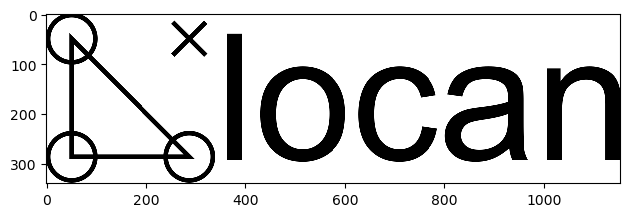

In [8]:
ski.io.imshow(logo);

## The Image class

In this example, the image is a plain numpy array. However, the image can be a more complex class with a specific interface, depending on the image library used.

Locan provides an adapter class to wrap any image class. The adapter class `locan.Image` provides a minimal standard interface.

In [9]:
Image?

Init signature:
Image(
    image: 'Any | None',
    is_rgb: 'bool' = False,
    meta: 'metadata_pb2.Metadata | None' = None,
) -> 'None'
Docstring:     
Adapter class for Image objects.

The original image object is referenced via self._image.
An array object that complies with the array API standard
is referenced in self.data
https://data-apis.org/array-api/latest/index.html

All attribute requests are looked up in the following order:
self, self.data, self._image

Parameters
----------
image:
    Image class to be adapted.
is_rgb:
    Whether the image is RGB or RGBA.
    If `False` the image is interpreted as a luminance image.
meta:
    Metadata about the current dataset.

Attributes
----------
data: ArrayApiObject | npt.NDArray | None
    Image data as array object following the array API standard.
    If no such array can be provided a numpy.NDArray is returned.
    Can be N dimensional. If the last dimension has length
    3 or 4 it can be interpreted as RGB or RGBA if is_rgb is

Objects should be instantiated through an appropriate constructor method.

In [10]:
[method for method in dir(Image) if method.startswith("from")]

['from_array', 'from_bins', 'from_napari', 'from_numpy', 'from_pillow']

### Image attributes

Upon instantiation `locan.Image` wraps the original image class and provides an array as `image.data`.

Any attribute request is forwarded first to image.data or - if not available - to the original images class referenced through image._image.

In [11]:
image = Image.from_numpy(array=logo, is_rgb=True)

In [12]:
image.is_rgb

True

In [13]:
image.shape

(340, 1154, 3)

In [14]:
image.size

1177080

In [15]:
image.dtype

dtype('uint8')

In [16]:
image.ndim

3

### The Image data attribute

Typically, image.data should present the image as an array object that can be used with the array API standard.

If this is not the case a numpy.NDArray is provided.

In [17]:
image = Image.from_array(array=logo, is_rgb=True)
type(image.data), image.dtype

(numpy.ndarray, dtype('uint8'))

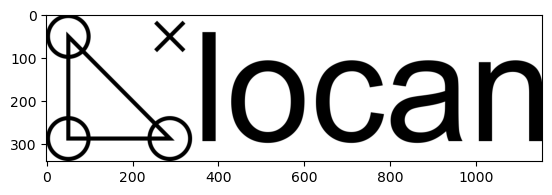

In [18]:
plt.imshow(image.data);

You might want to use methods according to the array API standard.

In [19]:
import numpy.array_api as xp

C:\Users\sod28mb\AppData\Local\Temp\ipykernel_24460\271726536.py:1: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  import numpy.array_api as xp


In [20]:
try:
    logo_as_float = xp.astype(image.data, np.float32)
except AttributeError as e:
    print("Exception:", e)

Exception: 'numpy.ndarray' object has no attribute '_array'


If an exception was raised, you can convert the array:

In [21]:
logo_array = xp.asarray(image.data)
print(type(logo_array), logo_array.dtype)

<class 'numpy.array_api._array_object.Array'> uint8


In [22]:
logo_as_float = xp.astype(logo_array, np.float32)
logo_as_float.dtype

dtype('float32')

In [23]:
[item for item in dir(logo_array) if not item.startswith("__")]

['T',
 '_array',
 '_check_allowed_dtypes',
 '_new',
 '_normalize_two_args',
 '_promote_scalar',
 '_validate_index',
 'device',
 'dtype',
 'mT',
 'ndim',
 'shape',
 'size',
 'to_device']

Alternatively, use a different method implementation:

In [24]:
try:
    from array_api_compat import array_namespace
    xp = array_namespace(image.data)
    logo_as_float = xp.astype(image.data, np.float32)
    print(type(logo_as_float), logo_as_float.dtype)
except ImportError as e:
    print("Exception:", e)

<class 'numpy.ndarray'> float32


### The Image bins attribute

To keep pixel coordinates with the image use the bins attribute:

In [25]:
image = Image.from_array(array=logo[:, :, 0], is_rgb=False)
image.shape

(340, 1154)

In [26]:
bins = lc.Bins(n_bins=image.shape, bin_range=[[10, 20],[100, 200]])
[edges[0:3] for edges in bins.bin_edges]

[array([10.        , 10.02941176, 10.05882353]),
 array([100.        , 100.08665511, 100.17331023])]

In [27]:
image.bins = bins
image.bins

### The Image meta attribute

Metadata that relates to some localization data should be kept under the meta attribute:

In [28]:
image = Image.from_array(array=logo[:, :, 0], is_rgb=False, meta={"comment": "Free text can go here..."})
image.meta

identifier: "50052c06-812b-409a-9766-fcfc63880025"
comment: "Free text can go here..."
creation_time {
  seconds: 1709568810
  nanos: 421510000
}

Additional metadata should be added in a separate attribute:

In [29]:
exif = {"Model": "Some Camera"}
image.exif = exif
image.exif

{'Model': 'Some Camera'}

## Modify the Image class

 To create an Image object from any other library object
    modify the initialization of self.data and other attributes accordingly.

In [30]:
class MyImage(Image):
    def __init__(self, image: "Any"):
        super().__init__(image=image)
        self.data = self._image

In [31]:
image = MyImage(image="special_image")
image.data

The data object is not compliant with the array API standard.


array('special_image', dtype='<U13')